In [1]:
# Important modules
import requests
import numpy as np 
import pandas as pd 
import os
import json
import time
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from PIL import Image
from io import BytesIO 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

## 1) Downloading **image_predictions.tsv** programatically
### 1.1. download

In [2]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_predection_file = requests.get(url)
file_name = url.split('/')[-1]

if not os.path.isfile(file_name):
    with open(file_name,'wb') as file:
        file.write(image_predection_file.content)

### 1.2. inspect tsv file contents in a DF to assure it is a flat file 

In [3]:
df_img_predection = pd.read_csv(file_name,sep='\t')

### 1.3. import Tweets archive file 'twitter-archive-enhanced.csv' contents in a DF to assure it is a flat file 

In [4]:
df_tw_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

## 2) Tweeter API - downloading JSON FILE (likes/reshares to be loaded to a dataframe)
### 2.1. Authentication

In [5]:
import tweepy

#consumer_key = 'YOUR CONSUMER KEY'
#consumer_secret = 'YOUR CONSUMER SECRET'
#access_token = 'YOUR ACCESS TOKEN'
#access_secret = 'YOUR ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

### 2.2. Downloading JSON file

In [6]:
start_time = time.time()
archive_tweet_ids_list = df_tw_archive_enhanced.tweet_id.values.tolist()
tweet_id_serial = len(archive_tweet_ids_list)
dict_not_found_tweets = {}
time_elapsed = time.time() - start_time

if not os.path.isfile('tweet_json.txt'):
    with open('tweet_json.txt','a') as json_to_text_file:
        for tweet_id in archive_tweet_ids_list:
            print('Tweet ID: {} | '.format(tweet_id), end='')
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')._json
                print(' Downloaded | remaining: {} | time elapsed: {} sec'.format(tweet_id_serial,int(time_elapsed)))
                json.dump(tweet, json_to_text_file)
                json_to_text_file.write('\n')
            except tweepy.TweepError as excep:
                print('  >Failed<  | remaining: {} | time elapsed: {} sec'.format(tweet_id_serial,int(time_elapsed)))
                dict_not_found_tweets[tweet_id] = excep
                pass 
            finally:
                tweet_id_serial -=1
                time_elapsed = time.time() - start_time 
            
end_time = time.time()
print('Overall Time spent downloading tweets JSON file: {} Sec(s).'.format(int(end_time - start_time)))

Overall Time spent downloading tweets JSON file: 0 Sec(s).


### 2.3. Exporting Errors to CSV / DataFrame

In [7]:
# saving the not-found-tweet ids for future use in case needed
if not os.path.isfile('not_found_tweet_ids.csv'):
    list_not_found_tweets = []
    for key, item in dict_not_found_tweets.items():
        list_not_found_tweets.append({'tweet_id': key,
                                    'error_code': item.api_code,
                                    'error_msg': item.response.text[34:-5]})
    df_not_found_tweets = pd.DataFrame(list_not_found_tweets, columns=list(list_not_found_tweets[0].keys()))
    df_not_found_tweets.to_csv('not_found_tweet_ids.csv', index=False)

else:
    df_not_found_tweets = pd.read_csv('not_found_tweet_ids.csv')

### 2.4. Reading tweet_id, retweet_count, favorite_count from the JSON file saved in step 2.2. above

In [8]:
df_updated_tweets_list = []
with open('tweet_json.txt') as json_text_file:
    while True:
        line = json_text_file.readline()
        if not line:
            break
        else:
            json_txt_to_dic = json.loads(line)
            df_updated_tweets_list.append({'tweet_id': json_txt_to_dic['id'],
                                           'retweet_count': json_txt_to_dic['retweet_count'],
                                           'favorite_count': json_txt_to_dic['favorite_count'],
                                           'followers_count': json_txt_to_dic['user']['followers_count']})

df_updated_tweets = pd.DataFrame(df_updated_tweets_list, columns=list(df_updated_tweets_list[0].keys()))

## _Mapping DataFrames to FilesNames_
### 1. df_img_predection (image-predictions.tsv)

.. Image Predection Data Frame

### 2. df_tw_archive_enhanced (twitter_archive_enhanced.csv) 

.. Twitter Archive

### 3. df_not_found_tweets (not_found_tweet_ids.csv) 

.. After redownloading tweets IDs some werent found or not accessible, Twitter not found IDs vs error msg

### 4. df_updated_tweets (tweet_json.txt)

.. Downloaded Twitter IDs from Tweepy .. Twitter archive researched via Twitter API and saved in line by line JSON format in txt file

## 3) Data *Assessment*
### 3.1. Visual Assessment
_Done via Visual Code Studio variables view, it can show the DataSet like an Excel table_

### 3.2. Programatic Assessment
_Result written before section **4** at the end_

In [9]:
print("Count of Tweet IDs in archive tweets dataset    | {}".format(df_tw_archive_enhanced.tweet_id.count()))
print("Count of Tweet IDs in updated tweets dataset    | {}".format(df_updated_tweets.tweet_id.count()))
print("Count of Tweet IDs in images prediction dataset | {}".format(df_img_predection.tweet_id.count()))

Count of Tweet IDs in archive tweets dataset    | 2356
Count of Tweet IDs in updated tweets dataset    | 2331
Count of Tweet IDs in images prediction dataset | 2075


In [10]:
df_tw_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [11]:
df_tw_archive_enhanced.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1361,703079050210877440,NaN,NaN,2016-02-26 04:48:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Butternut Cumberfloof. It's not wind...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703079050...,11,10,a,None,None,None,None
103,872486979161796608,NaN,NaN,2017-06-07 16:14:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We. Only. Rate. Dogs. Do not send in other thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872486979...,12,10,None,None,None,None,None
947,752519690950500352,NaN,NaN,2016-07-11 15:07:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Hopefully this puppo on a swing will help get ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/752519690...,11,10,None,None,None,None,puppo
408,823581115634085888,NaN,NaN,2017-01-23 17:20:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Crawford. He's quite h*ckin good at th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/823581115...,11,10,Crawford,None,None,None,None
933,753655901052166144,NaN,NaN,2016-07-14 18:22:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""The dogtor is in hahahaha no but seriously I'...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/753655901...,10,10,None,None,None,None,None


In [12]:
df_tw_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
df_tw_archive_enhanced.tweet_id.duplicated().sum()

0

In [14]:
df_tw_archive_enhanced.expanded_urls.duplicated().sum()

137

In [15]:
pd.set_option('display.max_colwidth', 200)
df_tw_archive_enhanced.query('rating_denominator != 10')[['tweet_id','text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [16]:
df_tw_archive_enhanced.query('rating_denominator.isnull() or rating_numerator.isnull()')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [17]:
df_tw_archive_enhanced[df_tw_archive_enhanced.retweeted_status_id.isnull() == False].shape[0]

181

In [18]:
df_img_predection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
df_img_predection.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1546,792394556390137856,https://pbs.twimg.com/media/Cv8moW9W8AIHOxR.jpg,2,cocker_spaniel,0.746387,True,Irish_setter,0.091615,True,miniature_poodle,0.061078,True
1751,824297048279236611,https://pbs.twimg.com/media/C3B9ypNWEAM1bVs.jpg,2,teddy,0.588230,False,jigsaw_puzzle,0.028910,False,doormat,0.022251,False
777,689835978131935233,https://pbs.twimg.com/media/CZLKJpDWQAA-5u4.jpg,1,collie,0.600186,True,Shetland_sheepdog,0.298939,True,borzoi,0.022616,True
189,669375718304980992,https://pbs.twimg.com/media/CUoZqaqWcAAA2MQ.jpg,1,Airedale,0.168762,True,Norfolk_terrier,0.107479,True,Lakeland_terrier,0.097846,True
1011,709449600415961088,https://pbs.twimg.com/media/Cdh4pgAW0AEKJ_a.jpg,2,Maltese_dog,0.780187,True,Dandie_Dinmont,0.074429,True,Norfolk_terrier,0.033776,True


In [20]:
df_img_predection.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [21]:
df_img_predection.jpg_url.duplicated().sum()

66

In [22]:
df_updated_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tweet_id         2331 non-null   int64
 1   retweet_count    2331 non-null   int64
 2   favorite_count   2331 non-null   int64
 3   followers_count  2331 non-null   int64
dtypes: int64(4)
memory usage: 73.0 KB


In [23]:
df_updated_tweets.sample()

,tweet_id,retweet_count,favorite_count,followers_count
2306,666353288456101888,64,194,8848831


In [24]:
df_updated_tweets.describe()

,tweet_id,retweet_count,favorite_count,followers_count
count,2.331000e+03,2331.000000,2331.000000,2.331000e+03
mean,7.419079e+17,2652.346203,7456.455598,8.848860e+06
std,6.823170e+16,4485.786181,11576.387100,6.424103e+01
min,6.660209e+17,1.000000,0.000000,8.848830e+06
25%,6.782670e+17,537.000000,1297.000000,8.848845e+06
50%,7.182469e+17,1241.000000,3243.000000,8.848854e+06
75%,7.986692e+17,3079.500000,9133.500000,8.848866e+06
max,8.924206e+17,76226.000000,153853.000000,8.849493e+06


## 3) Assessment Summary

    note: order of solving below issues might differ due to the nature of the data

### QUALITY ISSUES
#### **df_tw_archive_enhanced** table
1. missing expanded_url values.
2. Erroneous data type tweet_id (int not str), timestamp, retweeted_status_timestamp (obj not dt) columns
Inaccurate rating_numerator & rating_denominator for some tweet_ids ('835246439529840640', '738166403467907072', '722974582966214656', '716439118184652801', '682962037429899265', '666287406224695296', '786709082849828864', '778027034220126208', '749981277374128128', '680494726643068929'). Correct ratings can be seen in text column (13/10, 14/10, 10/10, 13/10, 11/10, 9/10, 9.75/10, 11.27/10, 17.76/10, 11.26/10) respectively.
3. Rating not exist for tweet_id = 670842764863651840, visually checking link, it is irrelevant.
4. Non-standard rating_denominator (!=10) for some records
5. Un-needed retweets data (obvious under retweeted_status_id column)
6. Missing retweet favourites counts for some tweet_id.


#### **df_img_predection** table
7. Erroneous data type tweet_id (int not str).
8. Capital and small starting letter for columns P1, P2 & P3.
9. Duplicate records in column jpg_url.
10. Missing stages records, data can be seen sometimes in text but not written in a standard way hence wasn’t extracted


#### **df_updated_tweets** table
11. Erroneous data type tweet_id (int not str).



### TIDINESS ISSUES

#### **df_tw_archive_enhanced** table.
1. retweets columns data are not needed for the analysis.
2. Retweets count & favourite counts are in df_updated_tweets_copy table and not in df_tw_archive_enhanced_copy table.
3. Four columns (doggo, floofer, pupper, puppo) representing one variable (dog_stage).

#### **df_img_predection** table
4. Multiple columns represent the same variable (p1, p2, p3) & (p1_dog, p2_dog, p3_dog).



## 4) Data Cleaning
### 4.1. Copying DataFrames to start clean up

In [25]:
# Copying dataframes for clean up. 
df_tw_archive_enhanced_copy = df_tw_archive_enhanced.copy()
df_img_predection_copy = df_img_predection.copy()
df_updated_tweets_copy = df_updated_tweets.copy()
df_not_found_tweets_copy = df_not_found_tweets.copy()

### 4.2. Starting a Series of Define, Code, Test
-------------
### **Define**
-------------
Generate a new URL for missing value in expanded_urls, url = https://twitter.com/dog_rates/status/tweet_id/photo/1

### **Code**

In [26]:
# collecting empty URLs
df_tw_archive_enhanced_copy_empty_url_list = df_tw_archive_enhanced_copy[df_tw_archive_enhanced_copy.expanded_urls.isnull()].index.to_list()

# Modifying URLs
for empty_url_row_index in df_tw_archive_enhanced_copy_empty_url_list:
    url_value = 'https://twitter.com/dog_rates/status/'+str(df_tw_archive_enhanced_copy.loc[empty_url_row_index, 'tweet_id'])+'/photo/1'
    df_tw_archive_enhanced_copy.loc[empty_url_row_index, 'expanded_urls'] = url_value

### **Test**

In [27]:
#filtering again to see if there is still empty URLs
df_tw_archive_enhanced_copy[df_tw_archive_enhanced_copy.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### **Define**
-------------
Convert tweet_id data type to String
Convert timestamp data type to datetime.
Convert retweeted_status_timestamp data type to datetime.

### **Code**

In [28]:
df_tw_archive_enhanced_copy.tweet_id = df_tw_archive_enhanced_copy.tweet_id.astype(str)
df_tw_archive_enhanced_copy.timestamp = pd.to_datetime(df_tw_archive_enhanced.timestamp)
df_tw_archive_enhanced_copy.retweeted_status_timestamp = pd.to_datetime(df_tw_archive_enhanced.retweeted_status_timestamp)

### **Test**

In [29]:
df_tw_archive_enhanced_copy.dtypes

tweet_id                                   object
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp    datetime64[ns, UTC]
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
dtype: object

### **Define**
-------------
Correct rating_numerator, rating_denominator of indexes [313, 1086, 1662, 1165, 1202, 2335] of tweet_id '835246439529840640', '738166403467907072', '722974582966214656', '716439118184652801', '682962037429899265', '666287406224695296', '786709082849828864', '778027034220126208', '749981277374128128', '680494726643068929' to (13/10, 14/10, 10/10, 13/10, 11/10, 9/10, 9.75/10, 11.27/10, 17.76/10, 11.26/10) respectiviely

### **Code**

In [30]:
tweets_correction_dict = {'835246439529840640': [13, 10],
                          '738166403467907072': [14, 10], 
                          '722974582966214656': [10, 10],
                          '716439118184652801': [13, 10], 
                          '682962037429899265': [11, 10], 
                          '666287406224695296': [9, 10],
                          '786709082849828864': [9.75, 10],
                          '778027034220126208': [11.27, 10],
                          '749981277374128128': [17.76, 10],
                          '680494726643068929': [11.26, 10]
                          }

for key, value in tweets_correction_dict.items():
    df_tw_archive_enhanced_copy.loc[df_tw_archive_enhanced_copy.query('tweet_id == "{}"'.format(key)).index,'rating_numerator'] = value[0]
    df_tw_archive_enhanced_copy.loc[df_tw_archive_enhanced_copy.query('tweet_id == "{}"'.format(key)).index,'rating_denominator'] = value[1]

### **Test**

In [31]:
df_tw_archive_enhanced_copy[df_tw_archive_enhanced_copy.tweet_id.isin(list(tweets_correction_dict.keys()))][['tweet_id', 'rating_numerator', 'rating_denominator']]

,tweet_id,rating_numerator,rating_denominator
313,835246439529840640,13.00,10
695,786709082849828864,9.75,10
763,778027034220126208,11.27,10
979,749981277374128128,17.76,10
1086,738166403467907072,14.00,10
1165,722974582966214656,10.00,10
1202,716439118184652801,13.00,10
1662,682962037429899265,11.00,10
1712,680494726643068929,11.26,10
2335,666287406224695296,9.00,10


### **Define**
-------------
delete record tweet_id = 670842764863651840. it's an outlier rating + original post seems not for a dog. 

### **Code**

In [32]:
df_tw_archive_enhanced_copy = df_tw_archive_enhanced_copy[df_tw_archive_enhanced_copy.tweet_id != '670842764863651840']

### **Test**

In [33]:
df_tw_archive_enhanced_copy.query('tweet_id == "670842764863651840"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### **Define**
-------------
Standardize rating_denominator to equal 10 using equation ((non-standard rating_numerator x 10) / non-standard rating_denominator) 

### **Code**

In [34]:
# Capturing Indexes of (rating_denominator > 10) to use them for a change.
list_tw_archive_enhanced_copy_not_standard_denominator = df_tw_archive_enhanced_copy.query('rating_denominator != 10').index.to_list()
for raw_index in list_tw_archive_enhanced_copy_not_standard_denominator:
    new_numerator = ((10 * df_tw_archive_enhanced_copy.loc[raw_index,'rating_numerator']) / df_tw_archive_enhanced_copy.loc[raw_index,'rating_denominator'])
    df_tw_archive_enhanced_copy.loc[raw_index,'rating_numerator'] = new_numerator
    df_tw_archive_enhanced_copy.loc[raw_index,'rating_denominator'] = 10

### **Test**

In [35]:
df_tw_archive_enhanced_copy.query('rating_denominator != 10').shape[0]

0

### **Define**
-------------
Change data type of df_img_predection_copy.tweet_id to string

### **Code**

In [36]:
df_img_predection_copy.tweet_id = df_img_predection_copy.tweet_id.astype(str)

### **Test**

In [37]:
df_img_predection_copy.tweet_id.dtypes

dtype('O')

### **Define**
-------------
Capitalize first letter of values under table df_img_predection_copy (Column P1, Column P2 & Column P3)

### **Code**

In [38]:
df_img_predection_copy.p1 = df_img_predection_copy.p1.apply(lambda x: x.capitalize())
df_img_predection_copy.p2 = df_img_predection_copy.p2.apply(lambda x: x.capitalize())
df_img_predection_copy.p3 = df_img_predection_copy.p3.apply(lambda x: x.capitalize())

In [39]:
df_img_predection_copy.sample(5)[['p1','p2','p3']]

,p1,p2,p3
1735,Golden_retriever,Labrador_retriever,Saluki
1592,Dough,Bakery,French_loaf
1497,Chihuahua,Miniature_pinscher,Toy_terrier
251,Norwich_terrier,Cairn,Norfolk_terrier
913,Kuvasz,Great_pyrenees,Samoyed


### **Test**

### **Define**
-------------
Drop the duplicated df_img_predection_copy.jpg_url values

### **Code**

In [40]:
df_img_predection_copy = df_img_predection_copy.drop_duplicates(['jpg_url'])

### **Test**

In [41]:
df_img_predection_copy[df_img_predection_copy.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### **Define**
-------------
Change data type of df_updated_tweets_copy.tweet_id to string

### **Code**

In [42]:
df_updated_tweets_copy.tweet_id = df_updated_tweets_copy.tweet_id.astype(str)

### **Test**

In [43]:
df_updated_tweets_copy.tweet_id.dtypes

dtype('O')

### **Define**
-------------
Combine the 4 columns doggo, floofer, pupper, puppo to one column called df_img_predection_copy.dog_stage

### **Code**

In [44]:
# adding the 4 columns + replacing the None word with an empty string
df_tw_archive_enhanced_copy['dog_stage'] = df_tw_archive_enhanced_copy.doggo.replace('None','') + df_tw_archive_enhanced_copy.floofer.replace('None','') + df_tw_archive_enhanced_copy.pupper.replace('None','') + df_tw_archive_enhanced_copy.puppo.replace('None','')

### **Test**

In [45]:
df_tw_archive_enhanced_copy.dog_stage.value_counts()

                1975
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

_Note: 14 records with multiple stages, word **doggo** is common between them_


### **Define**
-------------
Removing word doggo df_img_predection_copy.dog_stage values like (doggopupper, doggopuppo or doggofloofer)

### **Code**

In [46]:
df_tw_archive_enhanced_copy.dog_stage = df_tw_archive_enhanced_copy.dog_stage.apply(lambda x: x[5:] if x in ['doggopupper', 'doggofloofer', 'doggopuppo'] else x)

### **Test**

In [47]:
df_tw_archive_enhanced_copy.dog_stage.value_counts()

           1975
pupper      257
doggo        83
puppo        30
floofer      10
Name: dog_stage, dtype: int64

### **Define**
-------------
Extract dog stage for non-identified stage records from tweets text and put in df_img_predection_copy.dog_stage

### **Code**

In [48]:
# query text of non-identified dog_stage
archive_text_list = df_tw_archive_enhanced_copy.query('dog_stage == ""').text.to_list()

# Slicing text into words 
archive_text_words_list = [] 
for line in archive_text_list:
    words = line.split(' ')
    for word in words:
        if (word in archive_text_words_list) or (word.lower().startswith('http')):
            continue
        else:
            archive_text_words_list.append(word)   
			
# picking up words that may represent a dog_stage in corresponding dog_stage list
pupper_list = []
doggo_list = []
puppo_list = []
floofer_list = []
for word in archive_text_words_list:
    if (word.lower().startswith('pupper')) and (word not in pupper_list):
        pupper_list.append(word)
    if (word.lower().startswith('puppa')) and (word not in pupper_list):
        pupper_list.append(word)
    if (word.lower().startswith('puppu')) and (word not in pupper_list):
        pupper_list.append(word)
    elif (word.lower().startswith('dogg')) and (word not in doggo_list):
        doggo_list.append(word)
    elif (word.lower().startswith('pupp')) and (word not in puppo_list):
        puppo_list.append(word)
    elif (word.lower().startswith('floof')) and (word not in floofer_list):
        floofer_list.append(word) 
    else:
        pass

In [49]:
# inspecting value count before working 
df_tw_archive_enhanced_copy.dog_stage.value_counts()

           1975
pupper      257
doggo        83
puppo        30
floofer      10
Name: dog_stage, dtype: int64

In [50]:
# collecting indexes of non-identified dog_stage tweets
non_identified_dog_stage_index_list = df_tw_archive_enhanced_copy.query('dog_stage == ""').index.to_list()


# Assigning found dog_stage to the value column
for row_index in non_identified_dog_stage_index_list:
    post_text = df_tw_archive_enhanced_copy.loc[row_index].text 
    post_text_list = post_text.split(' ')
    for word in post_text_list:
        dog_stage_result = ''
        if ((word.lower().startswith('d')) or (word.lower().startswith('f')) or (word.lower().startswith('p'))):
            if word in pupper_list:
                dog_stage_result = 'pupper'
                df_tw_archive_enhanced_copy.loc[row_index,'dog_stage'] = dog_stage_result
            elif word in doggo_list:
                dog_stage_result = 'doggo'
                df_tw_archive_enhanced_copy.loc[row_index,'dog_stage'] = dog_stage_result
            elif word in puppo_list:
                dog_stage_result = 'puppo'
                df_tw_archive_enhanced_copy.loc[row_index,'dog_stage'] = dog_stage_result
            elif word in floofer_list:
                dog_stage_result = 'floofer'   
                df_tw_archive_enhanced_copy.loc[row_index,'dog_stage'] = dog_stage_result

### **Test**

In [51]:
# inspecting value count after working 
df_tw_archive_enhanced_copy.dog_stage.value_counts()

           1895
pupper      286
doggo       101
puppo        45
floofer      28
Name: dog_stage, dtype: int64

### **Define**
-------------
Convert df_img_predection_copy.dog_stage to catigorical column

### **Code**

In [52]:
df_tw_archive_enhanced_copy.dog_stage = df_tw_archive_enhanced_copy.dog_stage.astype('category')

### **Test**

In [53]:
df_tw_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2355 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2355 non-null   datetime64[ns, UTC]
 4   source                      2355 non-null   object             
 5   text                        2355 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2355 non-null   object             
 10  rating_numerator            2355 non-null   float64         

### **Define**
-------------
drop un-needed multiple dog stages columns

### **Code**

In [54]:
df_tw_archive_enhanced_copy = df_tw_archive_enhanced_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'],axis=1)

### **Test**

In [55]:
df_tw_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2355 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2355 non-null   datetime64[ns, UTC]
 4   source                      2355 non-null   object             
 5   text                        2355 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2355 non-null   object             
 10  rating_numerator            2355 non-null   float64         

### **Define**
-------------
Drop retweets by dropping df_tw_archive_enhanced_copy.retweeted_status_id which includes value

### **Code**

In [56]:
print('before dropping the tweets | {} row(s) exists'.format(df_tw_archive_enhanced_copy.shape[0]))
df_tw_archive_enhanced_copy = df_tw_archive_enhanced_copy[df_tw_archive_enhanced_copy.retweeted_status_id.isna()]

before dropping the tweets | 2355 row(s) exists


### **Test**

In [57]:
print('After dropping the tweets | {} row(s) exists'.format(df_tw_archive_enhanced_copy.shape[0]))

After dropping the tweets | 2174 row(s) exists


### **Define**
-------------
Merge df_tw_archive_enhanced & df_updated_tweets_copy to get likes and retweets count

### **Code**

In [58]:
df_tw_archive_enhanced_copy = pd.merge(df_tw_archive_enhanced_copy, df_updated_tweets_copy, on='tweet_id', how='left')

### **Test**

In [59]:
df_tw_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 0 to 2173
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2174 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2174 non-null   datetime64[ns, UTC]
 4   source                      2174 non-null   object             
 5   text                        2174 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      datetime64[ns, UTC]
 9   expanded_urls               2174 non-null   object             
 10  rating_numerator            2174 non-null   float64         

### **Define**
-------------
Dropping records of df_tw_archive_enhanced_copy which has no retweet or favorite records

### **Code**

In [60]:
print("Count of records with no retweet or favorite stats | {}".format(df_tw_archive_enhanced_copy[df_tw_archive_enhanced_copy.retweet_count.isna() | df_tw_archive_enhanced_copy.favorite_count.isna()].shape[0]))
df_tw_archive_enhanced_copy = df_tw_archive_enhanced_copy[~(df_tw_archive_enhanced_copy.retweet_count.isna() | df_tw_archive_enhanced_copy.favorite_count.isna())]


Count of records with no retweet or favorite stats | 7


### **Test**

In [61]:
print("Count of records with no retweet or favorite stats | {}".format(df_tw_archive_enhanced_copy[df_tw_archive_enhanced_copy.retweet_count.isna() | df_tw_archive_enhanced_copy.favorite_count.isna()].shape[0]))

Count of records with no retweet or favorite stats | 0


### **Define**
-------------
Dropping records of df_tw_archive_enhanced_copy which has no retweet or favorite records

### **Code**

In [62]:
df_tw_archive_enhanced_copy.source = df_tw_archive_enhanced_copy.source.apply(lambda x: re.split('>|<',x)[-3])

### **Test**

In [63]:
df_tw_archive_enhanced_copy.source.value_counts()

Twitter for iPhone     2035
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

### **Define**
-------------
Dropping reply tweets by dropping df_tw_archive_enhanced_copy.in_reply_to_status_id that has values

### **Code**

In [64]:
print("Before dropping reply tweets : {} rows(s)".format(df_tw_archive_enhanced_copy.shape[0]))
df_tw_archive_enhanced_copy = df_tw_archive_enhanced_copy[df_tw_archive_enhanced_copy.in_reply_to_status_id.isna()]

Before dropping reply tweets : 2167 rows(s)


### **Test**

In [65]:
print("After dropping reply tweets : {} rows(s)".format(df_tw_archive_enhanced_copy.shape[0]))

After dropping reply tweets : 2089 rows(s)


### **Define**
-------------
Dropping reply tweets by dropping df_tw_archive_enhanced_copy.in_reply_to_status_id that has values

### **Code**

In [66]:
df_tw_archive_enhanced_copy = df_tw_archive_enhanced_copy.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1)

### **Test**

In [67]:
df_tw_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2089 entries, 0 to 2173
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2089 non-null   object             
 1   timestamp           2089 non-null   datetime64[ns, UTC]
 2   source              2089 non-null   object             
 3   text                2089 non-null   object             
 4   expanded_urls       2089 non-null   object             
 5   rating_numerator    2089 non-null   float64            
 6   rating_denominator  2089 non-null   int64              
 7   name                2089 non-null   object             
 8   dog_stage           2089 non-null   category           
 9   retweet_count       2089 non-null   float64            
 10  favorite_count      2089 non-null   float64            
 11  followers_count     2089 non-null   float64            
dtypes: category(1), datetime64[ns, UTC

### **Define**
-------------
Summerize dog breed, confidence level from 6 columns to two columns breed, confidence  

### **Code**

In [68]:
df_img_predection_copy['breed'] = 'None'
df_img_predection_copy['confidence'] = 0

for index_num in df_img_predection_copy.index:
    if df_img_predection_copy.loc[index_num].p1_dog == True:
        df_img_predection_copy.loc[index_num, 'breed'] = df_img_predection_copy.loc[index_num].p1
        df_img_predection_copy.loc[index_num, 'confidence'] = df_img_predection_copy.loc[index_num].p1_conf
        continue

    elif df_img_predection_copy.loc[index_num].p2_dog == True:
        df_img_predection_copy.loc[index_num, 'breed'] = df_img_predection_copy.loc[index_num].p2
        df_img_predection_copy.loc[index_num, 'confidence'] = df_img_predection_copy.loc[index_num].p2_conf
        continue

    elif df_img_predection_copy.loc[index_num].p3_dog == True:
        df_img_predection_copy.loc[index_num, 'breed'] = df_img_predection_copy.loc[index_num].p3
        df_img_predection_copy.loc[index_num, 'confidence'] = df_img_predection_copy.loc[index_num].p3_conf
        continue
    
    else:
        df_img_predection_copy.loc[index_num, 'breed'] = 'None'
        df_img_predection_copy.loc[index_num, 'confidence'] = 0

### **Test**

In [69]:
df_img_predection_copy.loc[:, 'p1':'confidence'].sample(5)

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence
503,Wood_rabbit,0.785756,False,Hare,0.118181,False,Cardigan,0.043627,True,Cardigan,0.043627
1135,Saint_bernard,0.482050,True,Collie,0.202740,True,Borzoi,0.037976,True,Saint_bernard,0.482050
1211,Sunglasses,0.900864,False,Sunglass,0.040291,False,Snorkel,0.009333,False,None,0.000000
734,Refrigerator,0.799795,False,Medicine_chest,0.182538,False,Ice_bear,0.001431,False,None,0.000000
1179,Pug,0.751758,True,Tub,0.110748,False,Bathtub,0.104132,False,Pug,0.751758


### **Define**
-------------
converting confidence to a percentage integer

### **Code**   

In [70]:
df_img_predection_copy.confidence = (df_img_predection_copy.confidence * 100).astype(np.int64)

### **Test**  

In [71]:
df_img_predection_copy.loc[:, 'p1':'confidence'].sample(5)

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence
1948,Australian_terrier,0.207281,True,Irish_terrier,0.156296,True,German_shepherd,0.123536,True,Australian_terrier,20
1498,Chow,0.314265,True,Golden_retriever,0.300435,True,Australian_terrier,0.049487,True,Chow,31
1823,Ice_bear,0.330573,False,Soft-coated_wheaten_terrier,0.196476,True,Irish_terrier,0.073097,True,Soft-coated_wheaten_terrier,19
2059,Whippet,0.626152,True,Borzoi,0.194742,True,Saluki,0.027351,True,Whippet,62
1575,Golden_retriever,0.893775,True,Labrador_retriever,0.070140,True,Doormat,0.008419,False,Golden_retriever,89


### **Define**
-------------
Merging breed, confidence level from df_img_predection_copy to df_tw_archive_enhanced_copy

### **Code**   

In [72]:
df_tw_archive_enhanced_copy = pd.merge(df_tw_archive_enhanced_copy, df_img_predection_copy[['tweet_id', 'breed', 'confidence']], on='tweet_id', how='left')

### **Test** 

In [73]:
df_tw_archive_enhanced_copy.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,followers_count,breed,confidence
1543,677547928504967168,2015-12-17 17:56:29+00:00,Twitter for iPhone,Not much to say here. I just think everyone needs to see this. 12/10 https://t.co/AGag0hFHpe,https://twitter.com/dog_rates/status/677547928504967168/photo/1,12.0,10,None,,3547.0,6731.0,8848872.0,American_staffordshire_terrier,91.0
1305,689599056876867584,2016-01-20 00:03:21+00:00,Twitter for iPhone,Here we see 33 dogs posing for a picture. All get 11/10 for superb cooperation https://t.co/TRAri5iHzd,https://twitter.com/dog_rates/status/689599056876867584/photo/1,11.0,10,None,,5386.0,11442.0,8848868.0,Cocker_spaniel,7.0
2058,666418789513326592,2015-11-17 00:53:15+00:00,Twitter for iPhone,This is Walter. He is an Alaskan Terrapin. Loves outdated bandanas. One ear still working. Cool house plant. 10/10 https://t.co/qXpcwENTvn,https://twitter.com/dog_rates/status/666418789513326592/photo/1,10.0,10,Walter,,41.0,112.0,8848831.0,Toy_terrier,14.0
1773,671768281401958400,2015-12-01 19:10:13+00:00,Twitter for iPhone,When you try to recreate the scene from Lady &amp; The Tramp but then remember you don't have a significant other. 10/10 https://t.co/TASnD8Q08S,"https://twitter.com/dog_rates/status/671768281401958400/photo/1,https://twitter.com/dog_rates/status/671768281401958400/photo/1",10.0,10,None,,461.0,1127.0,8848830.0,Chihuahua,50.0
1386,684800227459624960,2016-01-06 18:14:31+00:00,Twitter for iPhone,Meet Theodore. He's dapper as hell. Probably owns horses. Uses 'summer' as a verb. Often quotes philosophers. 11/10 https://t.co/J3Ld4fRbSy,https://twitter.com/dog_rates/status/684800227459624960/photo/1,11.0,10,Theodore,,981.0,2686.0,8848870.0,Miniature_schnauzer,29.0


### **Define**
-------------
Remove rating_denominator column, no more needed.

### **Code**   

In [74]:
df_tw_archive_enhanced_copy = df_tw_archive_enhanced_copy.drop(['rating_denominator'], axis = 1)

### **Test**   

In [75]:
df_tw_archive_enhanced_copy.sample(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage,retweet_count,favorite_count,followers_count,breed,confidence
937,724004602748780546,2016-04-23 22:38:43+00:00,Twitter for iPhone,This is Luther. He saw a ghost. Spooked af. 11/10 hang in there pupper https://t.co/EdKG43VvEl,"https://twitter.com/dog_rates/status/724004602748780546/photo/1,https://twitter.com/dog_rates/status/724004602748780546/photo/1,https://twitter.com/dog_rates/status/724004602748780546/photo/1",11.0,Luther,pupper,1502.0,4102.0,8848866.0,Pug,1.0


### **Define**
-------------
Rename 'rating_numerator' to 'rating' in df_tw_archive_enhanced_copy

### **Code**   

In [76]:
df_tw_archive_enhanced_copy.rename(columns={'rating_numerator': 'rating'},inplace=True)

### **Test**   

In [77]:
df_tw_archive_enhanced_copy.sample(1)

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,followers_count,breed,confidence
1862,670385711116361728,2015-11-27 23:36:23+00:00,Twitter for iPhone,Meet Larry. He's a Panoramic Benzoate. Can shoot lasers out of his eyes. Very neat. Stuck in that position tho. 8/10 https://t.co/MAZx8MPF0S,https://twitter.com/dog_rates/status/670385711116361728/photo/1,8.0,Larry,,191.0,535.0,8848830.0,Whippet,17.0


### **Define**
-------------
rearrange columns in df_tw_archive_enhanced_copy to bring numeric columns closer to left

### **Code**  

In [78]:
df_tw_archive_enhanced_copy = df_tw_archive_enhanced_copy[['tweet_id', 'timestamp', 'rating', 'retweet_count', 'favorite_count', 'followers_count', 'breed', 'confidence', 'dog_stage', 'name', 'source', 'text', 'expanded_urls']]

### **Test**

In [79]:
df_tw_archive_enhanced_copy.sample(1)

,tweet_id,timestamp,rating,retweet_count,favorite_count,followers_count,breed,confidence,dog_stage,name,source,text,expanded_urls
1684,673711475735838725,2015-12-07 03:51:47+00:00,10.0,283.0,996.0,8848831.0,Maltese_dog,60.0,,None,Twitter for iPhone,🎶 HELLO FROM THE OTHER SIIIIIIIIDE 🎶 10/10 https://t.co/MTOOksRzvH,https://twitter.com/dog_rates/status/673711475735838725/photo/1


### **Define**
-------------
Adjust data types for (rating, retweet_count, favorite_count, followers_count) to integer from float

### **Code** 

In [80]:
df_tw_archive_enhanced_copy.rating = df_tw_archive_enhanced_copy.rating.astype(np.int64)
df_tw_archive_enhanced_copy.retweet_count = df_tw_archive_enhanced_copy.retweet_count.astype(np.int64)
df_tw_archive_enhanced_copy.favorite_count = df_tw_archive_enhanced_copy.favorite_count .astype(np.int64)
df_tw_archive_enhanced_copy.followers_count = df_tw_archive_enhanced_copy.followers_count.astype(np.int64)

# filling NaN values under confidence column to 0 
df_tw_archive_enhanced_copy.confidence.fillna(0, inplace=True)
df_tw_archive_enhanced_copy.confidence = df_tw_archive_enhanced_copy.confidence.astype(np.int64)

### **Test**

In [81]:
df_tw_archive_enhanced_copy.sample(5)

,tweet_id,timestamp,rating,retweet_count,favorite_count,followers_count,breed,confidence,dog_stage,name,source,text,expanded_urls
1941,668633411083464705,2015-11-23 03:33:22+00:00,10,1496,2641,8848831,Pekinese,58,,Churlie,Twitter for iPhone,This is Churlie. He likes bagels. 10/10 https://t.co/k8P6FZlzAG,"https://twitter.com/dog_rates/status/668633411083464705/photo/1,https://twitter.com/dog_rates/status/668633411083464705/photo/1"
352,817908911860748288,2017-01-08 01:40:55+00:00,12,801,4868,8848852,NaN,0,,None,Twitter for iPhone,Looks like he went cross-eyed trying way too hard to use the force. 12/10 \nhttps://t.co/bbuKxk0fM8,https://twitter.com/micahgrimes/status/817902080979599361
1999,667534815156183040,2015-11-20 02:47:56+00:00,8,490,770,8848831,Pembroke,43,,Frank,Twitter Web Client,"This is Frank (pronounced ""Fronq""). Too many boxing gloves, not enough passion. Frank is a lover not a fighter. 8/10 https://t.co/CpPxD28IpV",https://twitter.com/dog_rates/status/667534815156183040/photo/1
1746,672466075045466113,2015-12-03 17:23:00+00:00,12,497,1287,8848830,Cocker_spaniel,15,,Franq,Twitter for iPhone,This is Franq and Pablo. They're working hard getting ready for Christmas. 12/10 for both. Amazing pups https://t.co/8lKFBOQ2J5,https://twitter.com/dog_rates/status/672466075045466113/photo/1
719,754482103782404096,2016-07-17 01:05:25+00:00,10,1927,5239,8848858,None,0,,Milo,Twitter for iPhone,This is Milo. He's currently plotting his revenge. 10/10 https://t.co/ca0q9HM8II,https://twitter.com/dog_rates/status/754482103782404096/video/1


### **Define**
-------------
Fill breed NaN values with None for standardization

### **Code** 

In [82]:
df_tw_archive_enhanced_copy.breed.fillna('None', inplace=True)

### **Test** 

In [83]:
df_tw_archive_enhanced_copy[df_tw_archive_enhanced_copy.breed.isna()]

,tweet_id,timestamp,rating,retweet_count,favorite_count,followers_count,breed,confidence,dog_stage,name,source,text,expanded_urls


### **Define**
-------------
Replace underscore in breed names with a space

### **Code** 

In [84]:
df_tw_archive_enhanced_copy['breed'] = df_tw_archive_enhanced_copy['breed'].apply(lambda x: x.replace('_',' ').title() if x.find('_') != -1 else x)

### **Test** 

In [85]:
df_tw_archive_enhanced_copy.sample(5)

,tweet_id,timestamp,rating,retweet_count,favorite_count,followers_count,breed,confidence,dog_stage,name,source,text,expanded_urls
722,753655901052166144,2016-07-14 18:22:23+00:00,10,2144,5784,8848858,Miniature Pinscher,45,,None,Twitter for iPhone,"""The dogtor is in hahahaha no but seriously I'm very qualified and that tumor is definitely malignant"" 10/10 https://t.co/ULqThwWmLg",https://twitter.com/dog_rates/status/753655901052166144/photo/1
236,836380477523124226,2017-02-28 01:00:19+00:00,12,2938,14615,8848852,None,0,pupper,Ava,Twitter for iPhone,"This is Ava. She just blasted off. Streamline af. Aerodynamic as h*ck. One small step for pupper, one giant leap for pupkind. 12/10 https://t.co/W4KffrdX3Q",https://twitter.com/dog_rates/status/836380477523124226/photo/1
166,852553447878664193,2017-04-13 16:05:56+00:00,13,3320,15770,8848849,Bloodhound,18,,Jarod,Twitter for iPhone,This is Jarod. He likes having his belly brushed. Tongue ejects when you hit the right spot. 13/10 downright h*ckin adorable https://t.co/ArnxkyD2kC,"https://twitter.com/dog_rates/status/852553447878664193/photo/1,https://twitter.com/dog_rates/status/852553447878664193/photo/1"
649,766008592277377025,2016-08-17 20:27:34+00:00,11,494,3725,8848854,Welsh Springer Spaniel,72,,Angel,Twitter for iPhone,This is Angel. She stole the @ShopWeRateDogs shirt from her owner. Fits pretty well actually. 11/10 would forgive https://t.co/jaivZ1dcUL,https://twitter.com/dog_rates/status/766008592277377025/photo/1
1835,670755717859713024,2015-11-29 00:06:39+00:00,9,98,416,8848830,Keeshond,99,,Gin,Twitter for iPhone,Say hello to Gin &amp; Tonic. They're having a staring contest. Very very intense. 9/10 for both https://t.co/F6bI9dF16E,https://twitter.com/dog_rates/status/670755717859713024/photo/1


## 5) Save Data to CSV file

In [86]:
df_tw_archive_enhanced_copy.to_csv('twitter_archive_corrected.csv', index = False)

============================================================================================================================
----------


## 6) Visualization 
### 6.1. Reload Clean Data

In [87]:
df_clean_tweets = pd.read_csv('twitter_archive_corrected.csv')

### 6.2. Sanity check - Quality / Tidniss 

In [88]:
df_clean_tweets.sample(5)

,tweet_id,timestamp,rating,retweet_count,favorite_count,followers_count,breed,confidence,dog_stage,name,source,text,expanded_urls
611,772581559778025472,2016-09-04 23:46:12+00:00,10,1693,6466,8848854,Newfoundland,57,NaN,a,Twitter for iPhone,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,"https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1"
1836,670733412878163972,2015-11-28 22:38:01+00:00,8,476,905,8848830,None,0,NaN,Jerry,Twitter for iPhone,This is Jerry. He's a great listener. Low maintenance. Hard to get leash on tho. 8/10 still good dog https://t.co/NsDIt8Z80Z,https://twitter.com/dog_rates/status/670733412878163972/photo/1
1568,676617503762681856,2015-12-15 04:19:18+00:00,13,920,2788,8848872,Chihuahua,84,pupper,None,Twitter for iPhone,I promise this wasn't meant to be a cuteness overload account but ermergerd look at this cozy pupper. 13/10 https://t.co/mpQl2rJjDh,https://twitter.com/dog_rates/status/676617503762681856/photo/1
1315,688916208532455424,2016-01-18 02:49:58+00:00,11,846,2664,8848868,Pembroke,43,pupper,None,Twitter for iPhone,This pupper just wants to say hello. 11/10 would knock down fence for https://t.co/A8X8fwS78x,"https://twitter.com/dog_rates/status/688916208532455424/photo/1,https://twitter.com/dog_rates/status/688916208532455424/photo/1"
1612,675432746517426176,2015-12-11 21:51:30+00:00,12,545,1459,8848831,Labrador Retriever,98,pupper,None,Twitter for iPhone,Happy Friday. Here's some golden puppers. 12/10 for all https://t.co/wNkqAED6lG,"https://twitter.com/dog_rates/status/675432746517426176/photo/1,https://twitter.com/dog_rates/status/675432746517426176/photo/1,https://twitter.com/dog_rates/status/675432746517426176/photo/1"


In [89]:
# inspecting clean data
df_clean_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2089 non-null   int64 
 1   timestamp        2089 non-null   object
 2   rating           2089 non-null   int64 
 3   retweet_count    2089 non-null   int64 
 4   favorite_count   2089 non-null   int64 
 5   followers_count  2089 non-null   int64 
 6   breed            2089 non-null   object
 7   confidence       2089 non-null   int64 
 8   dog_stage        406 non-null    object
 9   name             2089 non-null   object
 10  source           2089 non-null   object
 11  text             2089 non-null   object
 12  expanded_urls    2089 non-null   object
dtypes: int64(6), object(7)
memory usage: 212.3+ KB


### 6.3. Adjusting the clean Datas' types
1. tweet_id to string
2. timestamp to date_time
3. dog_stage to categorical


In [90]:
df_clean_tweets.tweet_id = df_clean_tweets.tweet_id.astype(str)
df_clean_tweets.timestamp = pd.to_datetime(df_clean_tweets.timestamp)
df_clean_tweets.dog_stage = df_clean_tweets.dog_stage.astype('category')

In [91]:
df_clean_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   tweet_id         2089 non-null   object             
 1   timestamp        2089 non-null   datetime64[ns, UTC]
 2   rating           2089 non-null   int64              
 3   retweet_count    2089 non-null   int64              
 4   favorite_count   2089 non-null   int64              
 5   followers_count  2089 non-null   int64              
 6   breed            2089 non-null   object             
 7   confidence       2089 non-null   int64              
 8   dog_stage        406 non-null    category           
 9   name             2089 non-null   object             
 10  source           2089 non-null   object             
 11  text             2089 non-null   object             
 12  expanded_urls    2089 non-null   object             
dtypes: category(1), da

In [92]:
df_clean_tweets.head(5)

,tweet_id,timestamp,rating,retweet_count,favorite_count,followers_count,breed,confidence,dog_stage,name,source,text,expanded_urls
0,892420643555336193,2017-08-01 16:23:56+00:00,13,7546,35680,8848845,None,0,NaN,Phineas,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1
1,892177421306343426,2017-08-01 00:17:27+00:00,13,5593,30861,8848845,Chihuahua,32,NaN,Tilly,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1
2,891815181378084864,2017-07-31 00:18:03+00:00,12,3706,23198,8848845,Chihuahua,71,NaN,Archie,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1
3,891689557279858688,2017-07-30 15:58:51+00:00,13,7727,38985,8848845,Labrador Retriever,16,NaN,Darla,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1
4,891327558926688256,2017-07-29 16:00:24+00:00,12,8326,37238,8848845,Basset,55,NaN,Franklin,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1"


### 6.4. Inspecting Correlation

In [93]:
df_clean_tweets.corr()

,rating,retweet_count,favorite_count,followers_count,confidence
rating,1.000000,0.285095,0.370768,0.009977,0.203960
retweet_count,0.285095,1.000000,0.926358,-0.013791,0.011563
favorite_count,0.370768,0.926358,1.000000,-0.031281,0.064229
followers_count,0.009977,-0.013791,-0.031281,1.000000,-0.017043
confidence,0.203960,0.011563,0.064229,-0.017043,1.000000


#### Numbers above shows: Strong Relationship between **retweet_count** & **favorite count** >> Scatter Matrix will help visualizing that.


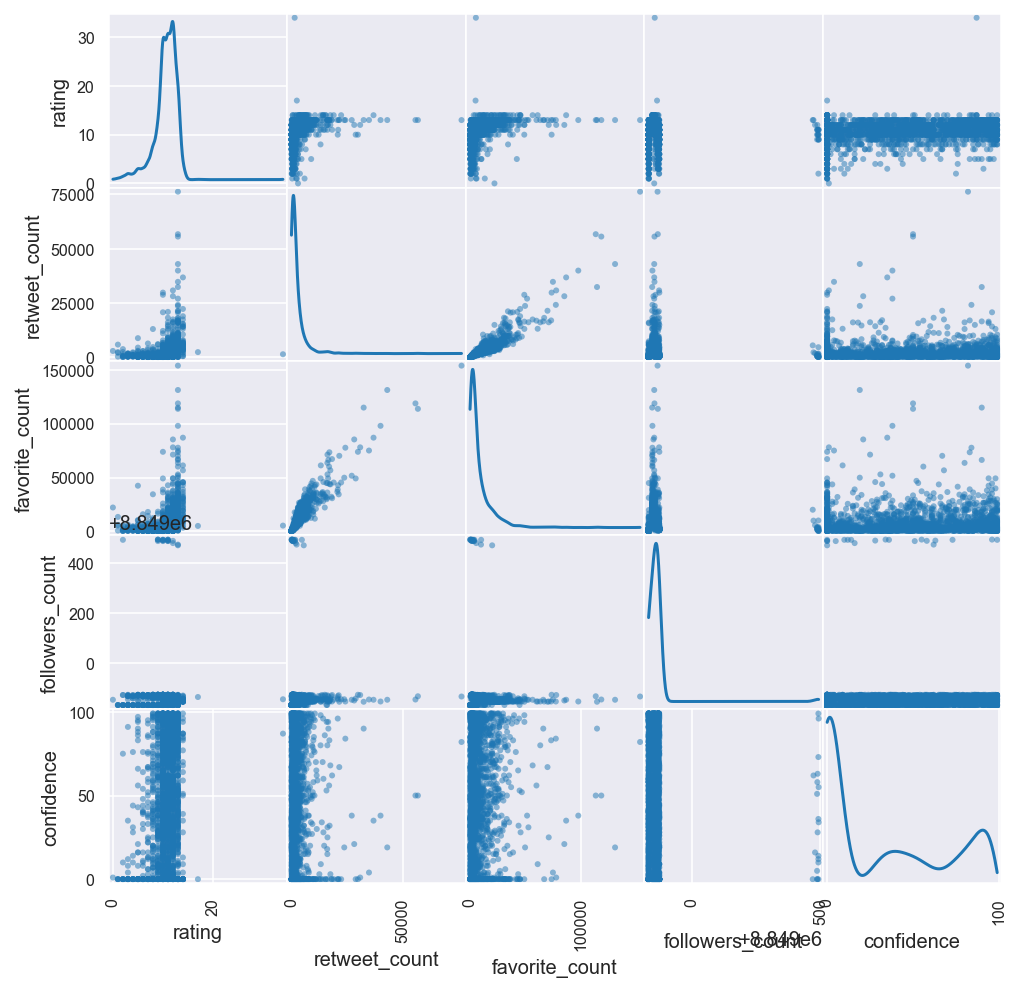

In [94]:
scatter_matrix_chart = pd.plotting.scatter_matrix(df_clean_tweets, figsize=(8, 8), marker = ".", diagonal="kde")

## 7) Questions & Answers

1. Is number of retweets impacts number of favorites?
2. What is the Top 10 famous breeds on WeRateDogs?
3. Which dog was the most famous (highest retweets)?
4. Does Rating impacts the favorite counter?
.
 

### 7.1. (Question) Is number of retweets impacts the number of favorites?

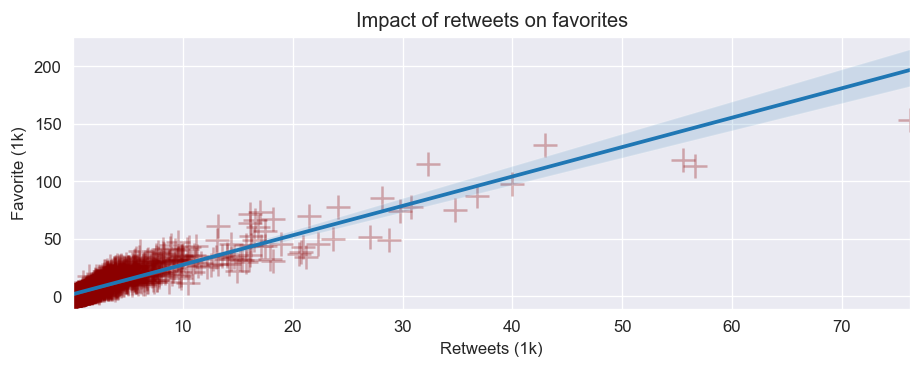

In [95]:
# source > https://python-graph-gallery.com/41-control-marker-features/
figure(num=None, figsize=(9, 3), dpi=60, facecolor='w', edgecolor='k')
sns.regplot(x=(df_clean_tweets.retweet_count) / 1000, y=(df_clean_tweets.favorite_count) / 1000, fit_reg=True, scatter_kws={"color":"darkred","alpha":0.3,"s":200}, marker='+')
plt.xlabel('Retweets (1k)')
plt.ylabel('Favorite (1k)')
plt.title('Impact of retweets on favorites')
plt.show()

### 7.1. (Answer) Yes, more retweets means more favorites.
----------------------

### 7.2. (Question) What is the top 10 famous breeds on WeRateDogs?
_considering that more retweets means more famous, lets check the maximum retweets per breed_

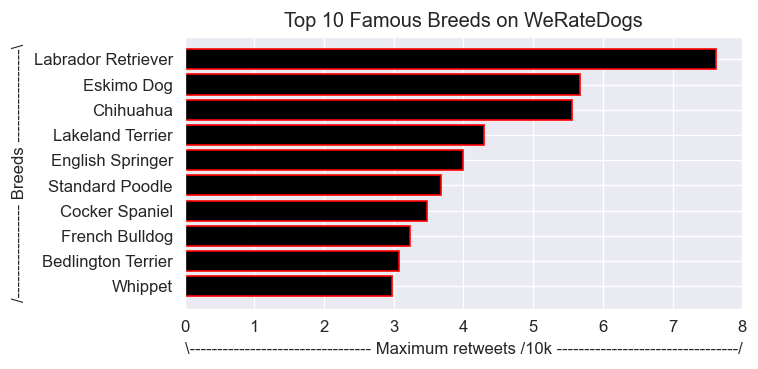

In [96]:
df_breed_famous = df_clean_tweets.groupby('breed').max()[['retweet_count','favorite_count']].sort_values(by='retweet_count').tail(10)
figure(num=None, figsize=(6, 3), dpi=60, facecolor='w', edgecolor='k')
plt.barh(df_breed_famous.index, df_breed_famous.retweet_count/10000, color=['black'], edgecolor='red')
plt.xlabel('\--------------------------------- Maximum retweets /10k ---------------------------------/')
plt.ylabel('/----------------- Breeds -----------------\\')
plt.title('Top 10 Famous Breeds on WeRateDogs')
plt.show()

------------------

### 7.3. (Question) Which dog was the most famous (highest retweets)?

Meet the most famous doggo who went viral with 76k retweets count and a score of 13/10


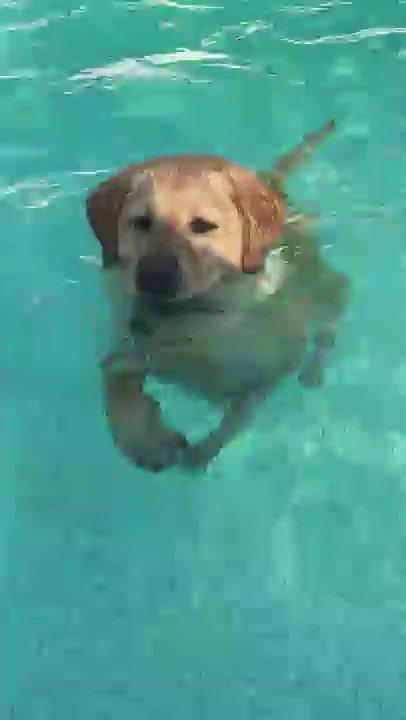

In [97]:
# looking for the retweet_id of most famous tweet (highest retweet_count)
most_famous_retweet = df_clean_tweets[df_clean_tweets.retweet_count == df_clean_tweets.retweet_count.max()].tweet_id.to_list()[0]
# bringing URL from img predection table
most_famous_retweet_img_url = df_img_predection.query('tweet_id == {}'.format(int(most_famous_retweet))).jpg_url.to_list()[0]
# Identifying the breed
most_famous_retweet_breed = df_clean_tweets[df_clean_tweets.retweet_count == df_clean_tweets.retweet_count.max()].breed.to_list()[0]
most_famous_retweet_rating = df_clean_tweets[df_clean_tweets.retweet_count == df_clean_tweets.retweet_count.max()].rating.to_list()[0]
most_famous_retweet_stage = df_clean_tweets[df_clean_tweets.retweet_count == df_clean_tweets.retweet_count.max()].dog_stage.to_list()[0]
# Setting up file name/ext.
most_famous_retweet_file_name = most_famous_retweet_breed.replace(' ','_')
most_famous_retweet_file_ext = most_famous_retweet_img_url.split('.')[-1]
most_famous_retweet_img_path = most_famous_retweet_file_name + '.' + most_famous_retweet_file_ext
# Downloading/Saving the image 
r = requests.get(most_famous_retweet_img_url)
i = Image.open(BytesIO(r.content))
i.save(most_famous_retweet_img_path)
# opening the image 
famous_dog = Image.open(most_famous_retweet_img_path)
print('Meet the most famous {} who went viral with {}k retweets count and a score of {}/10'.format(most_famous_retweet_stage, int(df_clean_tweets.retweet_count.max() / 1000), most_famous_retweet_rating))
famous_dog

-----------------------

### 7.4. (Question) Does Rating impacts the favorite counter?

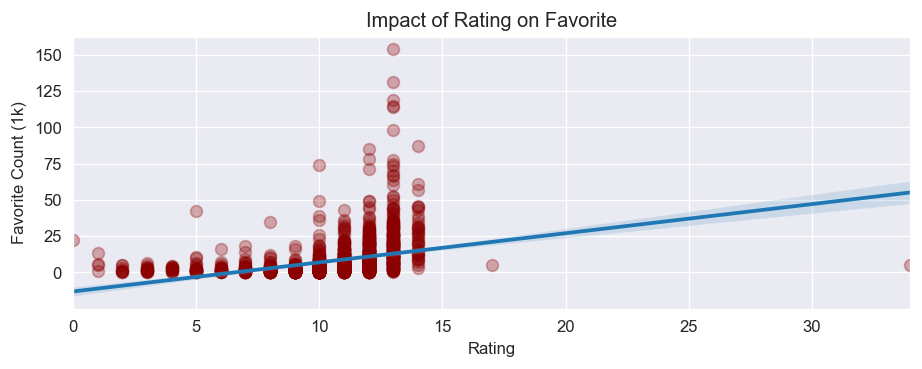

In [98]:
# source > https://python-graph-gallery.com/41-control-marker-features/
figure(num=None, figsize=(9, 3), dpi=60, facecolor='w', edgecolor='k')
sns.regplot(x=(df_clean_tweets.rating), y=(df_clean_tweets.favorite_count) / 1000, fit_reg=True, scatter_kws={"color":"darkred","alpha":0.3,"s":200}, marker='.')
plt.xlabel('Rating')
plt.ylabel('Favorite Count (1k)')
plt.title('Impact of Rating on Favorite')
plt.show()

### 7.4. (Answer) No, Rating has a weak correlation to favorite count
----------------------

In [99]:
# source https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reindex.html


# Group by dog_stage, rating
df_dog_stage_rating = df_clean_tweets.groupby(['dog_stage', 'rating']).count()['tweet_id']

#Dropping resulting NaN values
df_dog_stage_rating.dropna(inplace=True)

# calculating the total count of samples per dog_stage
df_dog_stage = df_clean_tweets.groupby('dog_stage').count()['tweet_id']

# Calculating proportion per dog stage
doggo_proportion = df_dog_stage_rating['doggo'] / df_dog_stage['doggo']
floofer_proportion = df_dog_stage_rating['floofer'] / df_dog_stage['floofer']
pupper_proportion = df_dog_stage_rating['pupper'] / df_dog_stage['pupper']
puppo_proportion = df_dog_stage_rating['puppo'] / df_dog_stage['puppo']

# Filling all empty ratings per dog_stage with zeros in all dog stages proportions to avoid graph mistakes
ratings_list = list(df_clean_tweets.rating.sort_values().unique())
doggo_proportion = doggo_proportion.reindex(ratings_list, fill_value = 0)
floofer_proportion = floofer_proportion.reindex(ratings_list, fill_value = 0)
pupper_proportion = pupper_proportion.reindex(ratings_list, fill_value = 0)
puppo_proportion = puppo_proportion.reindex(ratings_list, fill_value = 0)

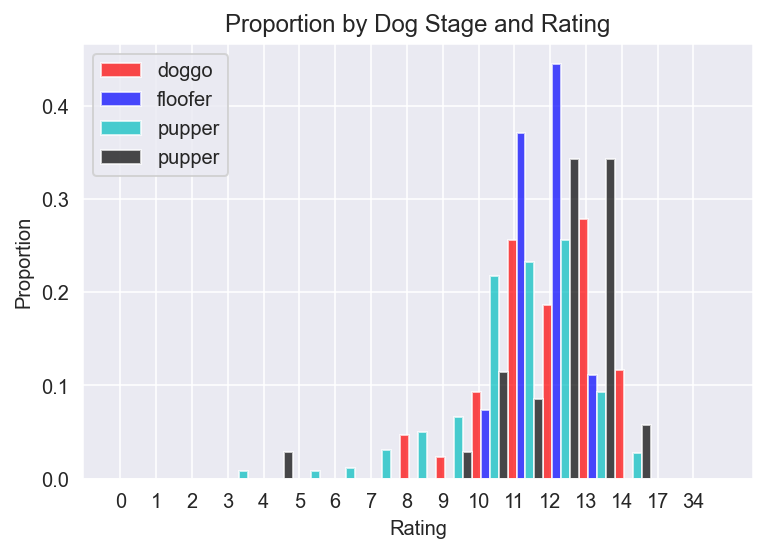

In [100]:
ind = np.arange(len(doggo_proportion))  # the x locations for the groups
width = 0.25       # the width of the bars

# plotting bars
doggo_bars = plt.bar(ind, doggo_proportion, width, color='r', alpha=.7, label='doggo')
floofer_bars = plt.bar(ind + width, floofer_proportion, width, color='b', alpha=.7, label='floofer')
pupper_bars = plt.bar(ind + (2*width), pupper_proportion, width, color='c', alpha=.7, label='pupper')
puppo_bars = plt.bar(ind + (3*width), puppo_proportion, width, color='k', alpha=.7, label='pupper')


# Title & Labels
plt.ylabel('Proportion')
plt.xlabel('Rating')
plt.title('Proportion by Dog Stage and Rating')
locations = ind + width / 4 #xticks locations
# I prefered to calculate the labels instead of manually writing them. 
labels = ratings_list #getting them then convert them to list
plt.xticks(locations, labels)
plt.legend(); # adding legend to the graph